In [1]:
"""
Made on July 10th, 2019
@author: Theodore Pena
@contact: theodore.pena@tufts.edu
"""

line_color = 'slategrey' # Color for the 10-panel plots
x_Delta = np.log10(54) # In our time units, the time between SDSS and HSC
default_Delta_value = -0.010100329832292771
data_path = '/home/tpena01/AGN_variability_project/Simulations/light_curves/custom_run/results__{}.bin'

# Setup and imports

In [2]:
import sys
print("sys version: {}".format(sys.version))
# This project is entirely in python 3.7

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# If you don't have an X server, line 7 might crash your kernel. Try '%matplotlib inline' instead.

import numpy as np
print("numpy version: {}".format(np.__version__))

import pandas as pd
print("pandas version: {}".format(pd.__version__))

from tqdm import tqdm
# This gives for loops progress bars.

from sklearn.metrics.pairwise import euclidean_distances
# We need this to match AGN from one catalog to another.

import random
# This helps choosing random numbers from our arrays
random.seed() # Randomize seed

from scipy.stats import chisquare
# For the chisquared test that we do at the very end


from IPython.core.display import display, HTML
# An alternate, cleaner take on the jupyter workspace
display(HTML("<style>.container { width:100% !important; }</style>"))

sys version: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy version: 1.16.4
pandas version: 0.24.2


In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

# Data extraction function

In [4]:
def extract_data(brightest_percent_lower=1, brightest_percent_upper=0, num_random_points=1000, t_max=10000, length_curve=2**24, num_curves=20):
    """
    Input: Parameters documented in the cell above
    Output: Graph of delta Eddington ratio as a function of delta time. 
    """
    
    if brightest_percent_lower <= brightest_percent_upper:
        sys.exit('Can\'t have an interval where the lower bound is greater than or equal to the upper bound. Remember, things are reversed. 100% is a reasonable lower bound, and brightest_percent_upper defaults to zero.')
        
        
    # Load the data
    default_curves = []
    for i in tqdm(range(num_curves + 1)):

        if i == 0:
            continue # for some reason the results files start at 1 and not 0

        _er_curve = np.zeros(length_curve, dtype=float)
        _er_curve = np.fromfile(data_path.format(str(i)))
        default_curves.append(_er_curve)

    default_curves = np.array(default_curves)

    default_curves = np.log10(default_curves) # Move everything into the log domain
    
    
    # Cut out the last t_max points
    cut_curves = np.zeros((np.array(list(default_curves.shape)) - np.array([0, t_max])))
    for i in tqdm(range(num_curves)):
        cut_curves[i, :] = default_curves[i, :-t_max]
    
    ##
    # Select all points brighter than brightest_percent_lower%
    num_brightest_lower = int(np.floor((cut_curves[0].shape[0] * (brightest_percent_lower/100))))
    
    if brightest_percent_lower == 100:
        num_brightest_lower = cut_curves[0].shape[0]
        
    if brightest_percent_lower == 0:
        sys.exit('Cannot use 0 as a lower bound.')
    
    else:
        indices_lower = []
        for i in tqdm(range(num_curves)):
            indices_lower.append(np.argpartition(cut_curves[i, :], -num_brightest_lower)[-num_brightest_lower:])

        indices_lower = np.array(indices_lower)
    
    
    # Select all points brighter than brightest_percent_upper%
    num_brightest_upper = int(np.floor((cut_curves[0].shape[0] * (brightest_percent_upper/100))))
    
    
    if brightest_percent_upper == 100:
        num_brightest_upper = cut_curves[0].shape[0]
        
    if brightest_percent_upper == 0:
        indices_upper = []
        for i in range(num_curves):
            indices_upper.append(np.array([]))
    
    else:
        indices_upper = []
        for i in tqdm(range(num_curves)):
            indices_upper.append(np.argpartition(cut_curves[i, :], -num_brightest_upper)[-num_brightest_upper:])

        indices_upper = np.array(indices_upper)
    
    
    indices = []
    for i in range(num_curves):
        indices.append(np.setdiff1d(indices_lower[i], indices_upper[i], assume_unique=True))
    
    ##
    
    # Randomly sample from the chosen indices
    chosen_indices = []
    for brightest_points_in_curve in tqdm(indices):
        chosen_indices.append(random.sample(list(brightest_points_in_curve), num_random_points))

    chosen_indices = np.array(chosen_indices, dtype=int)
    
    
    # Find the smallest number that we've chosen (We print this out later)
    small_points = []
    for i in tqdm(range(num_curves)):
        small_points.append(np.min(cut_curves[i][chosen_indices[i]]))

    smallest_point = "Min log(Edd): " + str(np.min(small_points))[:6]
    
    
    # Select all our points
    t_examine = np.logspace(0, np.log10(t_max), np.log(t_max)*10 + 1).astype(int)
    t_log = np.log10(t_examine) # Used later

    t_array = np.tile(t_examine, (num_random_points, 1))

    master_array = np.zeros(t_examine.shape, dtype=int)

    for i in tqdm(range(num_curves)):
        indices_array = np.tile(chosen_indices[i, :], (t_array.shape[1], 1)).T

        indices_array = indices_array + t_array    
        master_array = np.vstack((default_curves[i][indices_array], master_array))

    master_array = np.delete(master_array, -1, 0)

    starting_vals = np.copy(master_array[:, 0])
    for i in tqdm(range(master_array.shape[1])):
        master_array[:, i] = master_array[:, i] - starting_vals
        

    # Find our trends
    means = []
    stands = []

    for i in tqdm(range(master_array.shape[1])):
        means.append(np.mean(master_array[:, i]))
        stands.append(np.std(master_array[:, i]))

    means = np.array(means)
    stands = np.array(stands)
    
    
    # Get a line of best fit
    best_fit = np.poly1d(np.poly1d(np.polyfit(t_log.astype(float)[1:], means.astype(float)[1:], 1)))
    
    return (t_log, means, stands, best_fit, smallest_point)

# Main

In [5]:
t_log100, means100, stands100, best_fit100, smallest_point100 = extract_data(brightest_percent_lower=100, brightest_percent_upper=50)

t_log50, means50, stands50, best_fit50, smallest_point50 = extract_data(brightest_percent_lower=50, brightest_percent_upper=10)

t_log10, means10, stands10, best_fit10, smallest_point10 = extract_data(brightest_percent_lower=10, brightest_percent_upper=5)

t_log5, means5, stands5, best_fit5, smallest_point5 = extract_data(brightest_percent_lower=5, brightest_percent_upper=1)

t_log1, means1, stands1, best_fit1, smallest_point1 = extract_data(brightest_percent_lower=1, brightest_percent_upper=0.5)

t_log01, means01, stands01, best_fit01, smallest_point01 = extract_data(brightest_percent_lower=0.1, brightest_percent_upper=0.05)

t_log005, means005, stands005, best_fit005, smallest_point005 = extract_data(brightest_percent_lower=0.05, brightest_percent_upper=0.02)

t_log002, means002, stands002, best_fit002, smallest_point002 = extract_data(brightest_percent_lower=0.02, brightest_percent_upper=0.006)

t_loginf, meansinf, standsinf, best_fitinf, smallest_pointinf = extract_data(brightest_percent_lower=0.006)

100%|██████████| 21/21 [00:02<00:00,  6.55it/s]


KeyboardInterrupt: 

In [9]:
log_t_1 = [means100[np.where(t_log100==1)[0][0]], means50[np.where(t_log50==1)[0][0]], means10[np.where(t_log10==1)[0][0]], means5[np.where(t_log5==1)[0][0]], means1[np.where(t_log1==1)[0][0]], means05[np.where(t_log05==1)[0][0]], means01[np.where(t_log01==1)[0][0]], means005[np.where(t_log005==1)[0][0]], means002[np.where(t_log002==1)[0][0]], meansinf[np.where(t_loginf==1)[0][0]]]
log_t_2 = [means100[np.where(t_log100==2)[0][0]], means50[np.where(t_log50==2)[0][0]], means10[np.where(t_log10==2)[0][0]], means5[np.where(t_log5==2)[0][0]], means1[np.where(t_log1==2)[0][0]], means05[np.where(t_log05==2)[0][0]], means01[np.where(t_log01==2)[0][0]], means005[np.where(t_log005==2)[0][0]], means002[np.where(t_log002==2)[0][0]], meansinf[np.where(t_loginf==2)[0][0]]]
log_t_3 = [means100[np.where(t_log100==3)[0][0]], means50[np.where(t_log50==3)[0][0]], means10[np.where(t_log10==3)[0][0]], means5[np.where(t_log5==3)[0][0]], means1[np.where(t_log1==3)[0][0]], means05[np.where(t_log05==3)[0][0]], means01[np.where(t_log01==3)[0][0]], means005[np.where(t_log005==3)[0][0]], means002[np.where(t_log002==3)[0][0]], meansinf[np.where(t_loginf==3)[0][0]]]
log_t_4 = [means100[np.where(t_log100==4)[0][0]], means50[np.where(t_log50==4)[0][0]], means10[np.where(t_log10==4)[0][0]], means5[np.where(t_log5==4)[0][0]], means1[np.where(t_log1==4)[0][0]], means05[np.where(t_log05==4)[0][0]], means01[np.where(t_log01==4)[0][0]], means005[np.where(t_log005==4)[0][0]], means002[np.where(t_log002==4)[0][0]], meansinf[np.where(t_loginf==4)[0][0]]]

log_t_1_stands = np.log10(np.array([stands100[np.where(t_log100==1)[0][0]], stands50[np.where(t_log50==1)[0][0]], stands10[np.where(t_log10==1)[0][0]], stands5[np.where(t_log5==1)[0][0]], stands1[np.where(t_log1==1)[0][0]], stands05[np.where(t_log05==1)[0][0]], stands01[np.where(t_log01==1)[0][0]], stands005[np.where(t_log005==1)[0][0]], stands002[np.where(t_log002==1)[0][0]], standsinf[np.where(t_loginf==1)[0][0]]]))
log_t_2_stands = np.log10(np.array([stands100[np.where(t_log100==2)[0][0]], stands50[np.where(t_log50==2)[0][0]], stands10[np.where(t_log10==2)[0][0]], stands5[np.where(t_log5==2)[0][0]], stands1[np.where(t_log1==2)[0][0]], stands05[np.where(t_log05==2)[0][0]], stands01[np.where(t_log01==2)[0][0]], stands005[np.where(t_log005==2)[0][0]], stands002[np.where(t_log002==2)[0][0]], standsinf[np.where(t_loginf==2)[0][0]]]))
log_t_3_stands = np.log10(np.array([stands100[np.where(t_log100==3)[0][0]], stands50[np.where(t_log50==3)[0][0]], stands10[np.where(t_log10==3)[0][0]], stands5[np.where(t_log5==3)[0][0]], stands1[np.where(t_log1==3)[0][0]], stands05[np.where(t_log05==3)[0][0]], stands01[np.where(t_log01==3)[0][0]], stands005[np.where(t_log005==3)[0][0]], stands002[np.where(t_log002==3)[0][0]], standsinf[np.where(t_loginf==3)[0][0]]]))
log_t_4_stands = np.log10(np.array([stands100[np.where(t_log100==4)[0][0]], stands50[np.where(t_log50==4)[0][0]], stands10[np.where(t_log10==4)[0][0]], stands5[np.where(t_log5==4)[0][0]], stands1[np.where(t_log1==4)[0][0]], stands05[np.where(t_log05==4)[0][0]], stands01[np.where(t_log01==4)[0][0]], stands005[np.where(t_log005==4)[0][0]], stands002[np.where(t_log002==4)[0][0]], standsinf[np.where(t_loginf==4)[0][0]]]))

x = np.log10(np.array([100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.02, 0.006]))

# Delta value

In [8]:
Delta_value = means05[np.where(t_log05==x_Delta)][0]
print('For this set of parameters, Delta is ' + str(Delta_value - default_Delta_value) + '.')
print('Remember, a negative delta (approximately) means that the curve was steeper than the default plot of log Edd. Ratio as a function of time.')

For this set of parameters, Delta is -0.024968727160826692.
Remember, a negative delta (approximately) means that the curve was steeper than the default plot of log Edd. Ratio as a function of time.


# Graphs

## Comparison plot

### Gathering the data

#### Observed data

In [5]:
DATA_DIRECTORY='/home/tpena01/AGN_variability_project/Data/'
# Change '/home/tpena01' to a path leading to my variability repo, presuming you've alredy cloned it.
# If not, here's a link: https://github.com/openhearted99/AGN_variability_project

HSC_CATALOG_NAME = 'HSCpdr2QuasarCatalog.csv'
# If you're pulling data from your own HSC catalog, put your new catalog in
# .../AGN_variability_project, and change this.

In [6]:
dr7_old = pd.read_csv(DATA_DIRECTORY+'SDSSdr7QuasarCatalog.dat', skiprows=80, sep='\s+', engine='python', error_bad_lines=False, header=None)

Positions_of_dr7_old = np.transpose([dr7_old[1].values, dr7_old[2].values])
#version with flags
df_old = pd.read_csv(DATA_DIRECTORY+'194782.csv')
# give ra and dec
Positions_of_df_old=np.transpose([df_old['# ra'].values,df_old['dec'].values])

res_matching_old=[]
for j in tqdm(range(len(Positions_of_dr7_old))):
    # finds distance from each of the objects in dr7_old catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances_old=euclidean_distances([Positions_of_dr7_old[j]],Positions_of_df_old)
    # shortest distance
    shortest_distance_old=np.min(PositionOfQuasars_euclidean_distances_old[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index_old=np.where(PositionOfQuasars_euclidean_distances_old[0]==np.min(PositionOfQuasars_euclidean_distances_old[0]))[0][0]
    res_matching_old.append([shortest_distance_old,df_old.loc[shortest_distance_index_old].values])
    
matched_array_old=[]
matched_array_extended_SDSS_old=[]
for i in tqdm(range(len(res_matching_old))):
    if res_matching_old[i][0]>0.001:
        pass
    else:
        # extract columns 0,1,2,3,6,7,8,9,10,11 from SDSS, which are SDSS ID, ra, dec, redshift and psf measurments in different bands (g->[6,7],r->[8,9],i->[10,11])
        matched_array_old.append(np.concatenate((dr7_old.loc[i][[0,1,2,3,6,7,8,9,10,11]],res_matching_old[i][1])))
        # extract columns 1,2,3 which are ra, dec and redshift (plan to add mass from Schen catalog)
        matched_array_extended_SDSS_old.append(np.concatenate((dr7_old.loc[i][[1,2,3]],res_matching_old[i][1])))     
matched_array_old=np.array(matched_array_old)
matched_array_extended_SDSS_old=np.array(matched_array_extended_SDSS_old)

matched_array_filtered_old=matched_array_old[matched_array_old[:,4]>16]

# sdss psf-g band mag - HSC psf-g band mag
g_mag_dif_old=(matched_array_filtered_old[:,4]-matched_array_filtered_old[:,14+4]).astype(float)
# sdss psf-r band mag - HSC psf-r band mag
r_mag_dif_old=(matched_array_filtered_old[:,6]-matched_array_filtered_old[:,14+6]).astype(float)
# sdss psf-i band mag - HSC psf-i band
i_mag_dif_old=(matched_array_filtered_old[:,8]-matched_array_filtered_old[:,14+8]).astype(float)
# error sdss g band mag - HSC g band mag
g_mag_dif_err_old=np.sqrt(((matched_array_filtered_old[:,5]).astype(float))**2+((matched_array_filtered_old[:,14+5]).astype(float))**2)
# Error for the sdss psf-r band magnitude - HSC psf-r band magnitude
r_mag_dif_err_old=np.sqrt(((matched_array_filtered_old[:,7]).astype(float))**2+((matched_array_filtered_old[:,14+7]).astype(float))**2)
# Error for the sdss psf-i band magnitude - HSC psf-i band magnitude
i_mag_dif_err_old=np.sqrt(((matched_array_filtered_old[:,9]).astype(float))**2+((matched_array_filtered_old[:,14+9]).astype(float))**2)
# sdss psf-g band mag - HSC cmodel-g band mag
gcmodel_mag_dif_old=(matched_array_filtered_old[:,4]-matched_array_filtered_old[:,4+8]).astype(float)
# sdss psf-r band mag - HSC cmodel-r band mag
rcmodel_mag_dif_old=(matched_array_filtered_old[:,6]-matched_array_filtered_old[:,6+8]).astype(float)
# sdss psf-i band mag - HSC cmodel-i band
icmodel_mag_dif_old=(matched_array_filtered_old[:,8]-matched_array_filtered_old[:,8+8]).astype(float)
# error sdss g band mag - HSC cmodel-g band mag
gcmodel_mag_dif_err_old=np.sqrt(((matched_array_filtered_old[:,5]).astype(float))**2+((matched_array_filtered_old[:,5+8]).astype(float))**2)
# Error for the SDSS psf-r band magnitude - HSC cmodel-r band magnitude
rcmodel_mag_dif_err_old=np.sqrt(((matched_array_filtered_old[:,7]).astype(float))**2+((matched_array_filtered_old[:,7+8]).astype(float))**2)
# Error for the SDSS psf-i band magnitude - HSC cmodel-i band magnitude
icmodel_mag_dif_err_old=np.sqrt(((matched_array_filtered_old[:,9]).astype(float))**2+((matched_array_filtered_old[:,9+8]).astype(float))**2)

new_matched_data_array_old = np.insert(matched_array_filtered_old, 4, g_mag_dif_old, axis=1)
new_matched_data_array_old = np.insert(new_matched_data_array_old, 5, g_mag_dif_err_old, axis=1)
new_matched_data_array_old = np.insert(new_matched_data_array_old, 6, gcmodel_mag_dif_old, axis=1)
new_matched_data_array_old = np.insert(new_matched_data_array_old, 7, gcmodel_mag_dif_err_old, axis=1)
new_matched_data_array_old = np.insert(new_matched_data_array_old, 10, r_mag_dif_old, axis=1)
new_matched_data_array_old = np.insert(new_matched_data_array_old, 11, r_mag_dif_err_old, axis=1)
new_matched_data_array_old = np.insert(new_matched_data_array_old, 12, rcmodel_mag_dif_old, axis=1)
new_matched_data_array_old = np.insert(new_matched_data_array_old, 13, rcmodel_mag_dif_err_old, axis=1)
new_matched_data_array_old = np.insert(new_matched_data_array_old, 16, i_mag_dif_old, axis=1)
new_matched_data_array_old = np.insert(new_matched_data_array_old, 17, i_mag_dif_err_old, axis=1)
new_matched_data_array_old = np.insert(new_matched_data_array_old, 18, icmodel_mag_dif_old, axis=1)
new_matched_data_array_old = np.insert(new_matched_data_array_old, 19, icmodel_mag_dif_err_old, axis=1)

Skipping line 305: Expected 75 fields in line 305, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1633: Expected 75 fields in line 1633, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1745: Expected 75 fields in line 1745, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1828: Expected 75 fields in line 1828, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 3631: Expected 75 fields in line 3631, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4123: Expected 75 fields in line 4123, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4124: Expected 75 fields in line 4124, saw 76. Error could possibly be due to quotes bei

100%|██████████| 105645/105645 [00:12<00:00, 8431.31it/s] 


In [7]:
## NEW STUFF ##
dr7 = pd.read_csv(DATA_DIRECTORY+'SDSSdr7QuasarCatalog.dat', skiprows=80, sep='\s+', engine='python', error_bad_lines=False, header=None)
Positions_of_dr7 = np.transpose([dr7[1].values, dr7[2].values])

data = np.zeros(len(Positions_of_dr7), dtype={'names':('ra', 'dec'),
                          'formats':('f8','f8')})

data['ra'] = Positions_of_dr7[:,0]
data['dec'] =  Positions_of_dr7[:,1]

PositionOfQuasars = data

# Store the positions for later reference
np.save(DATA_DIRECTORY + 'PositionOfQuasars', PositionOfQuasars)
PositionOfQuasa = np.load(DATA_DIRECTORY + 'PositionOfQuasars.npy')
df = pd.read_csv(DATA_DIRECTORY + HSC_CATALOG_NAME)
Positions_of_df = np.transpose([df['# ra'].values, df['dec'].values])
res_matching = []
for j in tqdm(range(len(Positions_of_dr7))):
    
    # Find the distance between each object in the dr7 catalog and each object in the HSC catalog
    PositionOfQuasars_euclidean_distances = euclidean_distances([Positions_of_dr7[j]], Positions_of_df)
    
    # Find the shortest distance
    shortest_distance = np.min(PositionOfQuasars_euclidean_distances[0])
    
    # Match the elements
    shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances[0] == np.min(PositionOfQuasars_euclidean_distances[0]))[0][0]
    res_matching.append([shortest_distance, df.iloc[shortest_distance_index].values])

Skipping line 305: Expected 75 fields in line 305, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1633: Expected 75 fields in line 1633, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1745: Expected 75 fields in line 1745, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1828: Expected 75 fields in line 1828, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 3631: Expected 75 fields in line 3631, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4123: Expected 75 fields in line 4123, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4124: Expected 75 fields in line 4124, saw 76. Error could possibly be due to quotes bei

100%|██████████| 105645/105645 [00:42<00:00, 2473.90it/s]


In [8]:
# create array that has objects from SDSS that are found in HSC
matched_array = []
matched_array_extended_SDSS = []
for i in tqdm(range(len(res_matching))):
    
    if res_matching[i][0] > 0.001:
        pass
    
    else:
        # extract columns 0,1,2,3,6,7,8,9,10,11 from SDSS, which are SDSS ID, ra, dec, redshift and psf measurments in different bands (g->[6,7],r->[8,9],i->[10,11])
        matched_array.append(np.concatenate((dr7.iloc[i][[0, 1, 2, 3, 6, 7, 8, 9, 10, 11]], res_matching[i][1])))
        
        # extract columns 1,2,3 which are ra, dec and redshift (plan to add mass from Schen catalog)
        matched_array_extended_SDSS.append(np.concatenate((dr7.iloc[i][[1, 2, 3]], res_matching[i][1])))
        
matched_array = np.array(matched_array)
matched_array_extended_SDSS = np.array(matched_array_extended_SDSS)

# filter out QSO which failed measurment, (g-band set at 0 in SDSS catlog)
matched_array = matched_array[matched_array[:, 4] > 16]

100%|██████████| 105645/105645 [00:09<00:00, 11467.99it/s]


In [9]:
def extract_g_mag_data(matched_array, SDSSband = 4, HSCband = 18, info=1):
    """
    info just determines if you want a return value of (delta_band, redshift), or
    (delta_band, redshift, g_mag_SDSS)
    """
    # Set variables
    redshift_col = 3
    SDSSerr = SDSSband + 1
    HSCerr = HSCband + 1
    
    interpolated_center = 37
    saturated_center = 40
    edge_flag = 31
    
    
    matched_array_filtered = matched_array[np.logical_and.reduce((np.isfinite(matched_array[:, SDSSband].astype(float)), \
                                                                  np.isfinite(matched_array[:, HSCband].astype(float)), \
                                                                  np.isfinite(matched_array[:, SDSSerr].astype(float)), \
                                                                  np.isfinite(matched_array[:, HSCerr].astype(float)), \
                                                                  (matched_array[:, interpolated_center] == False), \
                                                                  (matched_array[:, saturated_center] == False), \
                                                                  (matched_array[:, edge_flag] == False), \
                                                                  ))]

    band_mag_dif = (matched_array_filtered[:, SDSSband] - matched_array_filtered[:, HSCband]).astype(float)
    band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, redshift_col]))
    
    band_mag_dif_err = np.sqrt(((matched_array_filtered[:, SDSSerr]).astype(float))**2 +
                               ((matched_array_filtered[:, HSCerr]).astype(float))**2)
    if info == 1:
        pass
        
    if info == 2:
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, SDSSband]))
        
    if info == 3:        
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, HSCband]))
    
    if info == 4:
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, interpolated_center]))
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, saturated_center]))
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, edge_flag]))
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, 1]))
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, 2]))
        
    return (band_mag_dif.T, band_mag_dif_err)

In [10]:
############ OLD STUFF
redshift_col_old = 3
data_col_old = 4
error_col_old = data_col_old + 1
g_mag_SDSS_col_old = 8
obj_per_bin_old = 100
data_array_old = new_matched_data_array_old
delta_band_and_redshift_old = data_array_old[:, [data_col_old, redshift_col_old]]
delta_band_and_redshift_old = np.hstack((delta_band_and_redshift_old, np.reshape(data_array_old[:, g_mag_SDSS_col_old], (len(data_array_old[:]),1)) ))
delta_band_and_redshift_sorted_and_split_old=np.array_split(delta_band_and_redshift_old[np.argsort(delta_band_and_redshift_old[:,1])], int(len(delta_band_and_redshift_old)/obj_per_bin_old))



# Next we sort each bin by g_mag
for i in tqdm(range(len(delta_band_and_redshift_sorted_and_split_old))):
    delta_band_and_redshift_sorted_and_split_old[i] = delta_band_and_redshift_sorted_and_split_old[i][np.argsort(delta_band_and_redshift_sorted_and_split_old[i][:, delta_band_and_redshift_sorted_and_split_old[i].shape[1]-1])]



res_delta_band_and_redshift_0_20_old = []
res_delta_band_and_redshift_20_40_old = []
res_delta_band_and_redshift_40_60_old = []
res_delta_band_and_redshift_60_80_old = []
res_delta_band_and_redshift_80_100_old = []
res_delta_band_and_redshift_all_old = []

res_delta_band_and_redshift_0_20_med_old = []
res_delta_band_and_redshift_20_40_med_old= []
res_delta_band_and_redshift_40_60_med_old= []
res_delta_band_and_redshift_60_80_med_old = []
res_delta_band_and_redshift_80_100_med_old = []
res_delta_band_and_redshift_all_med_old = []

res_delta_std_all_old = []

for i in tqdm(range(len(delta_band_and_redshift_sorted_and_split_old))):
    res_delta_band_and_redshift_0_20_old.append(np.mean(delta_band_and_redshift_sorted_and_split_old[i][:20],axis=0))
    res_delta_band_and_redshift_20_40_old.append(np.mean(delta_band_and_redshift_sorted_and_split_old[i][20:40],axis=0))
    res_delta_band_and_redshift_40_60_old.append(np.mean(delta_band_and_redshift_sorted_and_split_old[i][40:60],axis=0))
    res_delta_band_and_redshift_60_80_old.append(np.mean(delta_band_and_redshift_sorted_and_split_old[i][60:80],axis=0))
    res_delta_band_and_redshift_80_100_old.append(np.mean(delta_band_and_redshift_sorted_and_split_old[i][80:100],axis=0))
    res_delta_band_and_redshift_all_old.append(np.mean(delta_band_and_redshift_sorted_and_split_old[i],axis=0))

    res_delta_band_and_redshift_0_20_med_old.append(np.median(delta_band_and_redshift_sorted_and_split_old[i][:20],axis=0))
    res_delta_band_and_redshift_20_40_med_old.append(np.median(delta_band_and_redshift_sorted_and_split_old[i][20:40],axis=0))
    res_delta_band_and_redshift_40_60_med_old.append(np.median(delta_band_and_redshift_sorted_and_split_old[i][40:60],axis=0))
    res_delta_band_and_redshift_60_80_med_old.append(np.median(delta_band_and_redshift_sorted_and_split_old[i][60:80],axis=0))
    res_delta_band_and_redshift_80_100_med_old.append(np.median(delta_band_and_redshift_sorted_and_split_old[i][80:100],axis=0))
    res_delta_band_and_redshift_all_med_old.append(np.median(delta_band_and_redshift_sorted_and_split_old[i],axis=0))

    res_delta_std_all_old.append(np.array(delta_band_and_redshift_sorted_and_split_old[i][:,:], dtype=np.float64).std(axis=0))


res_delta_band_and_redshift_0_20_old = np.array(res_delta_band_and_redshift_0_20_old)
res_delta_band_and_redshift_20_40_old = np.array(res_delta_band_and_redshift_20_40_old)
res_delta_band_and_redshift_40_60_old = np.array(res_delta_band_and_redshift_40_60_old)
res_delta_band_and_redshift_60_80_old = np.array(res_delta_band_and_redshift_60_80_old)
res_delta_band_and_redshift_80_100_old = np.array(res_delta_band_and_redshift_80_100_old)
res_delta_band_and_redshift_all_old = np.array(res_delta_band_and_redshift_all_old)

res_delta_band_and_redshift_0_20_med_old = np.array(res_delta_band_and_redshift_0_20_med_old)
res_delta_band_and_redshift_20_40_med_old = np.array(res_delta_band_and_redshift_20_40_med_old)
res_delta_band_and_redshift_40_60_med_old = np.array(res_delta_band_and_redshift_40_60_med_old)
res_delta_band_and_redshift_60_80_med_old = np.array(res_delta_band_and_redshift_60_80_med_old)
res_delta_band_and_redshift_80_100_med_old = np.array(res_delta_band_and_redshift_80_100_med_old)
res_delta_band_and_redshift_all_med_old = np.array(res_delta_band_and_redshift_all_med_old)

res_delta_std_all_old = np.array(res_delta_std_all_old)

second_deg_fit_0_20_old = np.poly1d(np.polyfit(res_delta_band_and_redshift_0_20_old[:,1].astype(float), res_delta_band_and_redshift_0_20_old[:, 0].astype(float), 2))
second_deg_fit_20_40_old = np.poly1d(np.polyfit(res_delta_band_and_redshift_20_40_old[:,1].astype(float), res_delta_band_and_redshift_20_40_old[:, 0].astype(float), 2))
second_deg_fit_40_60_old = np.poly1d(np.polyfit(res_delta_band_and_redshift_40_60_old[:,1].astype(float), res_delta_band_and_redshift_40_60_old[:, 0].astype(float), 2))
second_deg_fit_60_80_old = np.poly1d(np.polyfit(res_delta_band_and_redshift_60_80_old[:,1].astype(float), res_delta_band_and_redshift_60_80_old[:, 0].astype(float), 2))
second_deg_fit_80_100_old = np.poly1d(np.polyfit(res_delta_band_and_redshift_80_100_old[:,1].astype(float), res_delta_band_and_redshift_80_100_old[:, 0].astype(float), 2))

second_deg_fit_0_20_med_old = np.poly1d(np.polyfit(res_delta_band_and_redshift_0_20_med_old[:,1].astype(float), res_delta_band_and_redshift_0_20_med_old[:, 0].astype(float), 2))
second_deg_fit_20_40_med_old = np.poly1d(np.polyfit(res_delta_band_and_redshift_20_40_med_old[:,1].astype(float), res_delta_band_and_redshift_20_40_med_old[:, 0].astype(float), 2))
second_deg_fit_40_60_med_old = np.poly1d(np.polyfit(res_delta_band_and_redshift_40_60_med_old[:,1].astype(float), res_delta_band_and_redshift_40_60_med_old[:, 0].astype(float), 2))
second_deg_fit_60_80_med_old = np.poly1d(np.polyfit(res_delta_band_and_redshift_60_80_med_old[:,1].astype(float), res_delta_band_and_redshift_60_80_med_old[:, 0].astype(float), 2))
second_deg_fit_80_100_med_old = np.poly1d(np.polyfit(res_delta_band_and_redshift_80_100_med_old[:,1].astype(float), res_delta_band_and_redshift_80_100_med_old[:, 0].astype(float), 2))
############



# Set variables
obj_per_bin = 100
smoothing_method='mean'
ylim=(-.4, .4)
num_to_choose=100


delta_band_and_redshift, _trash = extract_g_mag_data(matched_array, SDSSband=4, HSCband=18, info=2)

# Add on a row that represents the g_mag in SDSS. We'll sort by this later

delta_band_and_redshift_sorted_and_split=np.array_split(delta_band_and_redshift[np.argsort(delta_band_and_redshift[:,1])], int(len(delta_band_and_redshift)/obj_per_bin))



# Next we sort each bin by g_mag
for i in tqdm(range(len(delta_band_and_redshift_sorted_and_split))):
    delta_band_and_redshift_sorted_and_split[i] = delta_band_and_redshift_sorted_and_split[i][np.argsort(delta_band_and_redshift_sorted_and_split[i][:, delta_band_and_redshift_sorted_and_split[i].shape[1]-1])]

res_delta_band_and_redshift_0_20 = []
res_delta_band_and_redshift_20_40 = []
res_delta_band_and_redshift_40_60 = []
res_delta_band_and_redshift_60_80 = []
res_delta_band_and_redshift_80_100 = []
res_delta_band_and_redshift_all = []

res_delta_band_and_redshift_0_20_med = []
res_delta_band_and_redshift_20_40_med = []
res_delta_band_and_redshift_40_60_med = []
res_delta_band_and_redshift_60_80_med = []
res_delta_band_and_redshift_80_100_med = []
res_delta_band_and_redshift_all_med = []

res_delta_std_all = []

for i in tqdm(range(len(delta_band_and_redshift_sorted_and_split))):
    res_delta_band_and_redshift_0_20.append(np.mean(delta_band_and_redshift_sorted_and_split[i][:20],axis=0))
    res_delta_band_and_redshift_20_40.append(np.mean(delta_band_and_redshift_sorted_and_split[i][20:40],axis=0))
    res_delta_band_and_redshift_40_60.append(np.mean(delta_band_and_redshift_sorted_and_split[i][40:60],axis=0))
    res_delta_band_and_redshift_60_80.append(np.mean(delta_band_and_redshift_sorted_and_split[i][60:80],axis=0))
    res_delta_band_and_redshift_80_100.append(np.mean(delta_band_and_redshift_sorted_and_split[i][80:100],axis=0))
    res_delta_band_and_redshift_all.append(np.mean(delta_band_and_redshift_sorted_and_split[i],axis=0))
    
    res_delta_band_and_redshift_0_20_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][:20],axis=0))
    res_delta_band_and_redshift_20_40_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][20:40],axis=0))
    res_delta_band_and_redshift_40_60_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][40:60],axis=0))
    res_delta_band_and_redshift_60_80_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][60:80],axis=0))
    res_delta_band_and_redshift_80_100_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][80:100],axis=0))
    res_delta_band_and_redshift_all_med.append(np.median(delta_band_and_redshift_sorted_and_split[i],axis=0))

    res_delta_std_all.append(np.array(delta_band_and_redshift_sorted_and_split[i][:,:], dtype=np.float64).std(axis=0))




res_delta_band_and_redshift_0_20 = np.array(res_delta_band_and_redshift_0_20)
res_delta_band_and_redshift_20_40 = np.array(res_delta_band_and_redshift_20_40)
res_delta_band_and_redshift_40_60 = np.array(res_delta_band_and_redshift_40_60)
res_delta_band_and_redshift_60_80 = np.array(res_delta_band_and_redshift_60_80)
res_delta_band_and_redshift_80_100 = np.array(res_delta_band_and_redshift_80_100)
res_delta_band_and_redshift_all = np.array(res_delta_band_and_redshift_all)


res_delta_band_and_redshift_0_20_med = np.array(res_delta_band_and_redshift_0_20_med)
res_delta_band_and_redshift_20_40_med = np.array(res_delta_band_and_redshift_20_40_med)
res_delta_band_and_redshift_40_60_med = np.array(res_delta_band_and_redshift_40_60_med)
res_delta_band_and_redshift_60_80_med = np.array(res_delta_band_and_redshift_60_80_med)
res_delta_band_and_redshift_80_100_med = np.array(res_delta_band_and_redshift_80_100_med)
res_delta_band_and_redshift_all_med = np.array(res_delta_band_and_redshift_all_med)

res_delta_std_all = np.array(res_delta_std_all)

second_deg_fit_0_20 = np.poly1d(np.polyfit(res_delta_band_and_redshift_0_20[:,1].astype(float), res_delta_band_and_redshift_0_20[:, 0].astype(float), 2))
second_deg_fit_20_40 = np.poly1d(np.polyfit(res_delta_band_and_redshift_20_40[:,1].astype(float), res_delta_band_and_redshift_20_40[:, 0].astype(float), 2))
second_deg_fit_40_60 = np.poly1d(np.polyfit(res_delta_band_and_redshift_40_60[:,1].astype(float), res_delta_band_and_redshift_40_60[:, 0].astype(float), 2))
second_deg_fit_60_80 = np.poly1d(np.polyfit(res_delta_band_and_redshift_60_80[:,1].astype(float), res_delta_band_and_redshift_60_80[:, 0].astype(float), 2))
second_deg_fit_80_100 = np.poly1d(np.polyfit(res_delta_band_and_redshift_80_100[:,1].astype(float), res_delta_band_and_redshift_80_100[:, 0].astype(float), 2))

second_deg_fit_0_20_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_0_20_med[:,1].astype(float), res_delta_band_and_redshift_0_20_med[:, 0].astype(float), 2))
second_deg_fit_20_40_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_20_40_med[:,1].astype(float), res_delta_band_and_redshift_20_40_med[:, 0].astype(float), 2))
second_deg_fit_40_60_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_40_60_med[:,1].astype(float), res_delta_band_and_redshift_40_60_med[:, 0].astype(float), 2))
second_deg_fit_60_80_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_60_80_med[:,1].astype(float), res_delta_band_and_redshift_60_80_med[:, 0].astype(float), 2))
second_deg_fit_80_100_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_80_100_med[:,1].astype(float), res_delta_band_and_redshift_80_100_med[:, 0].astype(float), 2))

100%|██████████| 44/44 [00:00<00:00, 1802.96it/s]


#### Simulated data

In [11]:
t_log05, means05, stands05, best_fit05, smallest_point05 = extract_data(brightest_percent_lower=0.5, brightest_percent_upper=0.1)

100%|██████████| 93/93 [00:00<00:00, 3145.73it/s]


### Converting to the right space

In [12]:
time_for_comparison = np.power(10*np.ones(t_log05.shape), t_log05)

In [13]:
# Convert t_log05 from hundreds of days to years
time_for_comparison = time_for_comparison*((100)/(365))

In [14]:
# Convert from time to redshift
z_log05 = 14.85/time_for_comparison - 1

In [15]:
# Convert from mean log eddington ratio to magnitude
magnitudes = means05*2.5

In [67]:
np.save('delta magnitudes (y-axis)', magnitudes)
np.save('redshifts (x-axis)', z_log05)

### Plotting our results

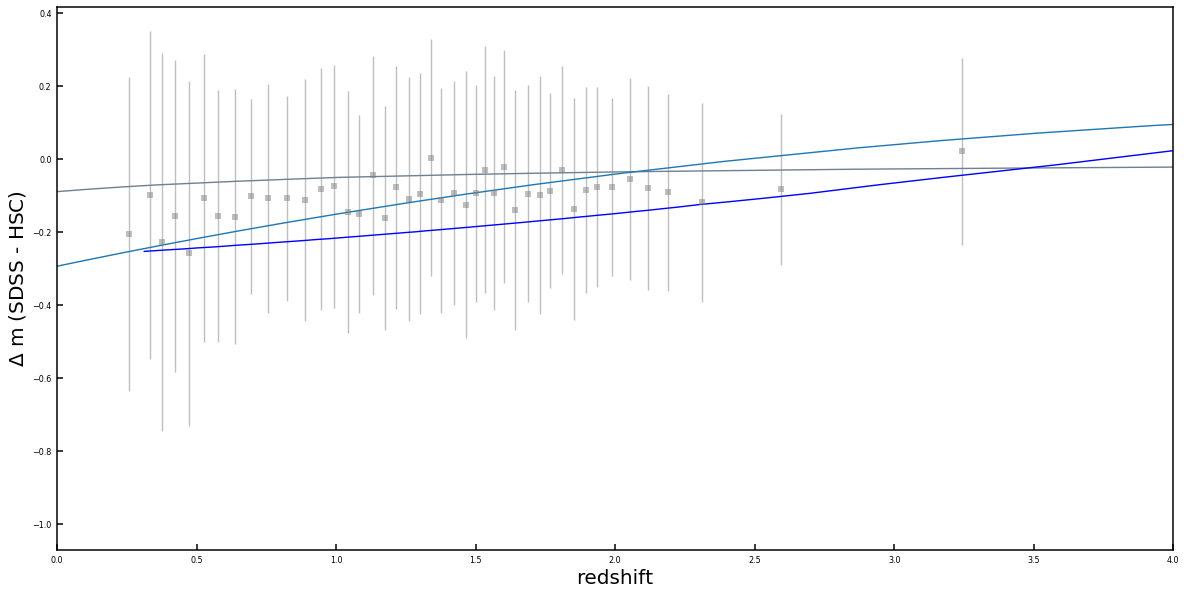

In [66]:
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, figsize=(20, 10))
    
    #ax.set_title('Mean change in log(Edd. Ratio) as a function of chosen percent. Data from: '+ data_path, fontsize=13)
    ax.tick_params(direction='in', length=6, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.set_xlabel('redshift', fontsize=20)
    ax.set_ylabel('$\Delta$ m (SDSS - HSC)', fontsize=20)
    ax.set_xlim([0, 4])
    #ax.set_ylim([-0.1, 0.04])
    
    ax.plot(z_log05, magnitudes, color=line_color )
    ax.errorbar(res_delta_band_and_redshift_all[:,1], res_delta_band_and_redshift_all[:,0], yerr=res_delta_std_all[:,0], color='grey', fmt='s', alpha=.5)
    ax.plot(res_delta_band_and_redshift_all_old[:,1], second_deg_fit_0_20_old(res_delta_band_and_redshift_0_20_old[:,1].astype(float)), color='blue')
    ax.plot(z_log05, line(z_log05))
    
plt.savefig('emulation of observed trend with simulated data.pdf', bbox_inches='tight')  
plt.show()

In [60]:
line = np.poly1d(np.polyfit(z_log05, magnitudes, 4))

In [55]:
simulated_values = line(res_delta_band_and_redshift_all[:,1]).astype(float)

In [ ]:
chisquare_val = chisquare()

## 10-panel plots

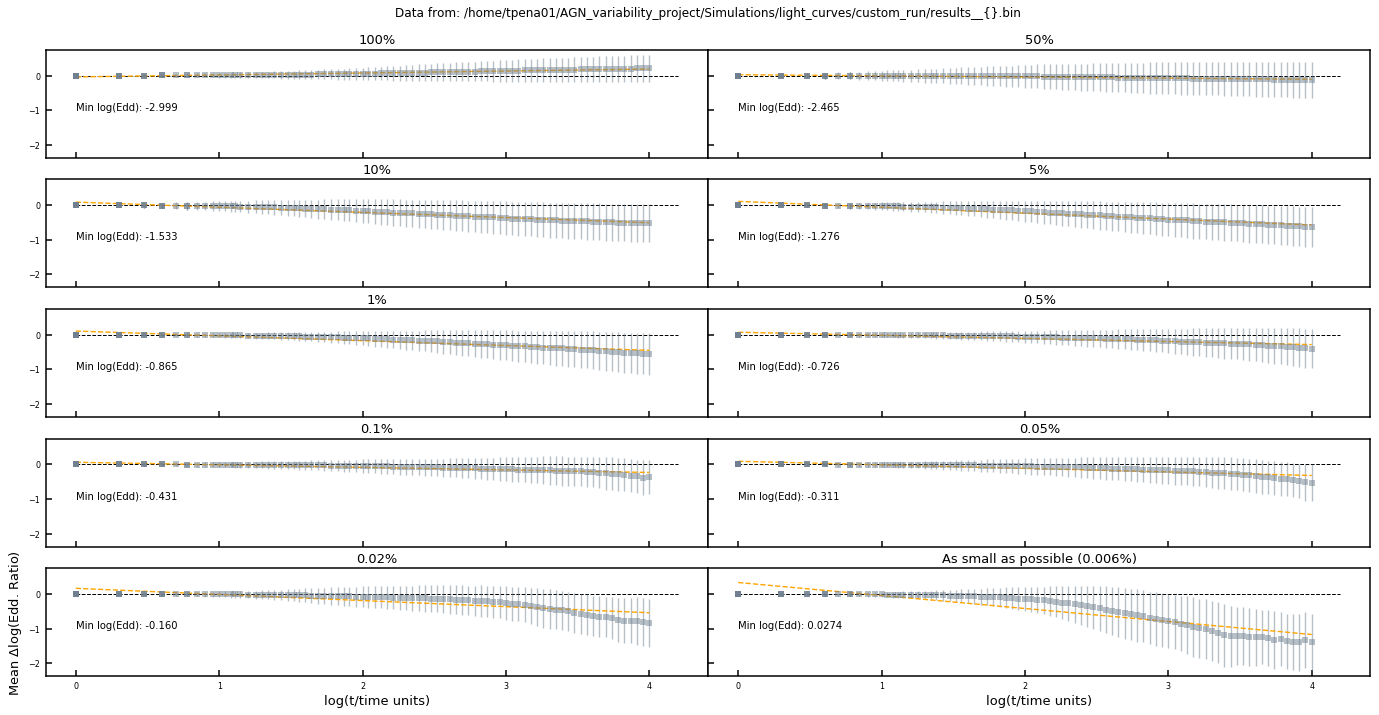

In [11]:
# Delta Eddington ratio plots
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(5, 2, figsize=(20, 10), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1], 'wspace':0, 'left':0.04, 'right':0.96, 'bottom':0.05, 'top':0.92})
    fig.suptitle('Data from: ' + data_path)
    ax[0,0].set_title('100%', fontsize=13)
    ax[0,0].tick_params(direction='in', length=6, width=1.5)
    ax[0,0].spines['top'].set_linewidth(1.5)
    ax[0,0].spines['right'].set_linewidth(1.5)
    ax[0,0].spines['bottom'].set_linewidth(1.5)
    ax[0,0].spines['left'].set_linewidth(1.5)
    
    ax[0,0].hlines(0, 0, t_log100[-1] + 0.2, linewidth=1, linestyle='--')
    ax[0,0].errorbar(t_log100, means100, yerr=stands100, fmt='s', alpha=0.5, color=line_color)
    ax[0,0].plot(t_log100[1:], best_fit100(t_log100[1:].astype(float)), ls='--', color='orange')
    
    ax[0,0].text(0, -1, smallest_point100)
    
    
    
    ax[0,1].set_title('50%', fontsize=13)
    ax[0,1].tick_params(direction='in', length=6, width=1.5)
    ax[0,1].spines['top'].set_linewidth(1.5)
    ax[0,1].spines['right'].set_linewidth(1.5)
    ax[0,1].spines['bottom'].set_linewidth(1.5)
    ax[0,1].spines['left'].set_linewidth(1.5)
    
    ax[0,1].hlines(0, 0, t_log50[-1] +0.2, linewidth=1, linestyle='--')
    ax[0,1].errorbar(t_log50, means50, yerr=stands50, fmt='s', alpha=0.5, color=line_color)
    ax[0,1].plot(t_log50[1:], best_fit50(t_log50[1:].astype(float)), ls='--', color='orange')
    
    ax[0,1].text(0, -1, smallest_point50)
    
    
    
    ax[1,0].set_title('10%', fontsize=13)
    ax[1,0].tick_params(direction='in', length=6, width=1.5)
    ax[1,0].spines['top'].set_linewidth(1.5)
    ax[1,0].spines['right'].set_linewidth(1.5)
    ax[1,0].spines['bottom'].set_linewidth(1.5)
    ax[1,0].spines['left'].set_linewidth(1.5)
    
    ax[1,0].hlines(0, 0, t_log10[-1] +0.2, linewidth=1, linestyle='--')
    ax[1,0].errorbar(t_log10, means10, yerr=stands10, fmt='s', alpha=0.5, color=line_color)
    ax[1,0].plot(t_log10[1:], best_fit10(t_log10[1:].astype(float)), ls='--', color='orange')
    
    ax[1,0].text(0, -1, smallest_point10)
    
    
    
    ax[1,1].set_title('5%', fontsize=13)
    ax[1,1].tick_params(direction='in', length=6, width=1.5)
    ax[1,1].spines['top'].set_linewidth(1.5)
    ax[1,1].spines['right'].set_linewidth(1.5)
    ax[1,1].spines['bottom'].set_linewidth(1.5)
    ax[1,1].spines['left'].set_linewidth(1.5)
    
    ax[1,1].hlines(0,  0, t_log5[-1] +0.2, linewidth=1, linestyle='--')
    ax[1,1].errorbar(t_log5, means5, yerr=stands5, fmt='s', alpha=0.5, color=line_color)
    ax[1,1].plot(t_log5[1:], best_fit5(t_log5[1:].astype(float)), ls='--', color='orange')
    
    ax[1,1].text(0, -1, smallest_point5)
    
    
    
    ax[2,0].set_title('1%', fontsize=13)
    ax[2,0].tick_params(direction='in', length=6, width=1.5)
    ax[2,0].spines['top'].set_linewidth(1.5)
    ax[2,0].spines['right'].set_linewidth(1.5)
    ax[2,0].spines['bottom'].set_linewidth(1.5)
    ax[2,0].spines['left'].set_linewidth(1.5)
    
    ax[2,0].hlines(0, 0, t_log1[-1] +0.2, linewidth=1, linestyle='--')
    ax[2,0].errorbar(t_log1, means1, yerr=stands1, fmt='s', alpha=0.5, color=line_color)
    ax[2,0].plot(t_log1[1:], best_fit1(t_log1[1:].astype(float)), ls='--', color='orange')
    
    ax[2,0].text(0, -1, smallest_point1)
    

    
    
    ax[2,1].set_title('0.5%', fontsize=13)
    ax[2,1].tick_params(direction='in', length=6, width=1.5)
    ax[2,1].spines['top'].set_linewidth(1.5)
    ax[2,1].spines['right'].set_linewidth(1.5)
    ax[2,1].spines['bottom'].set_linewidth(1.5)
    ax[2,1].spines['left'].set_linewidth(1.5)
    
    ax[2,1].hlines(0, 0, t_log05[-1] +0.2, linewidth=1, linestyle='--')
    ax[2,1].errorbar(t_log05, means05, yerr=stands05, fmt='s', alpha=0.5, color=line_color)
    ax[2,1].plot(t_log05[1:], best_fit05(t_log05[1:].astype(float)), ls='--', color='orange')
    
    ax[2,1].text(0, -1, smallest_point05)
    
    
    ax[3,0].set_title('0.1%', fontsize=13)
    ax[3,0].tick_params(direction='in', length=6, width=1.5)
    ax[3,0].spines['top'].set_linewidth(1.5)
    ax[3,0].spines['right'].set_linewidth(1.5)
    ax[3,0].spines['bottom'].set_linewidth(1.5)
    ax[3,0].spines['left'].set_linewidth(1.5)
    
    ax[3,0].hlines(0, 0, t_log01[-1] +0.2, linewidth=1, linestyle='--')
    ax[3,0].errorbar(t_log01, means01, yerr=stands01, fmt='s', alpha=0.5, color=line_color)
    ax[3,0].plot(t_log01[1:], best_fit01(t_log01[1:].astype(float)), ls='--', color='orange')
    
    ax[3,0].text(0, -1, smallest_point01)
    

    
    
    ax[3,1].set_title('0.05%', fontsize=13)
    ax[3,1].tick_params(direction='in', length=6, width=1.5)
    ax[3,1].spines['top'].set_linewidth(1.5)
    ax[3,1].spines['right'].set_linewidth(1.5)
    ax[3,1].spines['bottom'].set_linewidth(1.5)
    ax[3,1].spines['left'].set_linewidth(1.5)
    
    ax[3,1].hlines(0, 0, t_log005[-1] +0.2, linewidth=1, linestyle='--')
    ax[3,1].errorbar(t_log005, means005, yerr=stands005, fmt='s', alpha=0.5, color=line_color)
    ax[3,1].plot(t_log005[1:], best_fit005(t_log005[1:].astype(float)), ls='--', color='orange')
    
    ax[3,1].text(0, -1, smallest_point005)
    
    
    
    ax[4,0].set_title('0.02%', fontsize=13)
    ax[4,0].tick_params(direction='in', length=6, width=1.5)
    ax[4,0].spines['top'].set_linewidth(1.5)
    ax[4,0].spines['right'].set_linewidth(1.5)
    ax[4,0].spines['bottom'].set_linewidth(1.5)
    ax[4,0].spines['left'].set_linewidth(1.5)
    ax[4,0].set_xlabel('log(t/time units)', fontsize=13)
    ax[4,0].set_ylabel('Mean $\Delta$log(Edd. Ratio)', fontsize=13)
    
    ax[4,0].hlines(0, 0, t_log002[-1] +0.2, linewidth=1, linestyle='--')
    ax[4,0].errorbar(t_log002, means002, yerr=stands002, fmt='s', alpha=0.5, color=line_color)
    ax[4,0].plot(t_log002[1:], best_fit002(t_log002[1:].astype(float)), ls='--', color='orange')
    
    ax[4,0].text(0, -1, smallest_point002)
    
    
    
    ax[4,1].set_title('As small as possible (0.006%)', fontsize=13)
    ax[4,1].tick_params(direction='in', length=6, width=1.5)
    ax[4,1].spines['top'].set_linewidth(1.5)
    ax[4,1].spines['right'].set_linewidth(1.5)
    ax[4,1].spines['bottom'].set_linewidth(1.5)
    ax[4,1].spines['left'].set_linewidth(1.5)
    ax[4,1].set_xlabel('log(t/time units)', fontsize=13)
    
    ax[4,1].hlines(0, 0, t_loginf[-1] +0.2, linewidth=1, linestyle='--')
    ax[4,1].errorbar(t_loginf, meansinf, yerr=standsinf, fmt='s', alpha=0.5, color=line_color)
    ax[4,1].plot(t_loginf[1:], best_fitinf(t_loginf[1:].astype(float)), ls='--', color='orange')
    
    ax[4,1].text(0, -1, smallest_pointinf)
    
plt.savefig('10-panel_eddington_plot.pdf', bbox_inches='tight')  
plt.show()

/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeW

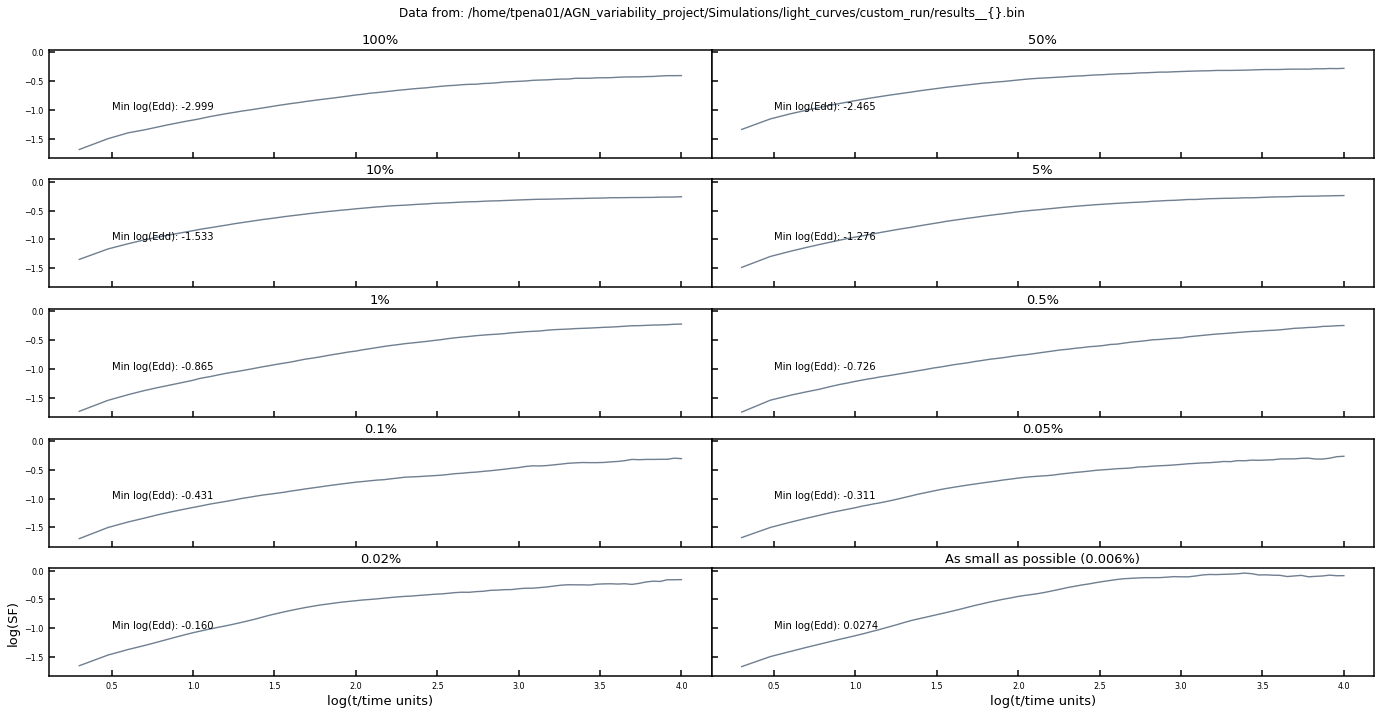

In [12]:
# Structure function plots
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(5, 2, figsize=(20, 10), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1], 'wspace':0, 'left':0.04, 'right':0.96, 'bottom':0.05, 'top':0.92})
    fig.suptitle('Data from: ' + data_path)
    
    ax[0,0].set_title('100%', fontsize=13)
    ax[0,0].tick_params(direction='in', length=6, width=1.5)
    ax[0,0].spines['top'].set_linewidth(1.5)
    ax[0,0].spines['right'].set_linewidth(1.5)
    ax[0,0].spines['bottom'].set_linewidth(1.5)
    ax[0,0].spines['left'].set_linewidth(1.5)
    
    
    ax[0,0].plot(t_log100[1:], np.log10(stands100[1:]), color=line_color)
    
    ax[0,0].text(0.5, -1, smallest_point100)
    
    
    
    ax[0,1].set_title('50%', fontsize=13)
    ax[0,1].tick_params(direction='in', length=6, width=1.5)
    ax[0,1].spines['top'].set_linewidth(1.5)
    ax[0,1].spines['right'].set_linewidth(1.5)
    ax[0,1].spines['bottom'].set_linewidth(1.5)
    ax[0,1].spines['left'].set_linewidth(1.5)
    
    
    ax[0,1].plot(t_log50[1:], np.log10(stands50[1:]), color=line_color)
    
    ax[0,1].text(0.5, -1, smallest_point50)
    
    
    
    ax[1,0].set_title('10%', fontsize=13)
    ax[1,0].tick_params(direction='in', length=6, width=1.5)
    ax[1,0].spines['top'].set_linewidth(1.5)
    ax[1,0].spines['right'].set_linewidth(1.5)
    ax[1,0].spines['bottom'].set_linewidth(1.5)
    ax[1,0].spines['left'].set_linewidth(1.5)
    
    
    ax[1,0].plot(t_log10[1:], np.log10(stands10[1:]), color=line_color)
    
    ax[1,0].text(0.5, -1, smallest_point10)
    
    
    
    ax[1,1].set_title('5%', fontsize=13)
    ax[1,1].tick_params(direction='in', length=6, width=1.5)
    ax[1,1].spines['top'].set_linewidth(1.5)
    ax[1,1].spines['right'].set_linewidth(1.5)
    ax[1,1].spines['bottom'].set_linewidth(1.5)
    ax[1,1].spines['left'].set_linewidth(1.5)
    
    
    ax[1,1].plot(t_log5[1:], np.log10(stands5[1:]), color=line_color)
    
    ax[1,1].text(0.5, -1, smallest_point5)
    
    
    
    ax[2,0].set_title('1%', fontsize=13)
    ax[2,0].tick_params(direction='in', length=6, width=1.5)
    ax[2,0].spines['top'].set_linewidth(1.5)
    ax[2,0].spines['right'].set_linewidth(1.5)
    ax[2,0].spines['bottom'].set_linewidth(1.5)
    ax[2,0].spines['left'].set_linewidth(1.5)
    
    
    ax[2,0].plot(t_log1[1:], np.log10(stands1[1:]), color=line_color)
    
    ax[2,0].text(0.5, -1, smallest_point1)
    

    
    
    ax[2,1].set_title('0.5%', fontsize=13)
    ax[2,1].tick_params(direction='in', length=6, width=1.5)
    ax[2,1].spines['top'].set_linewidth(1.5)
    ax[2,1].spines['right'].set_linewidth(1.5)
    ax[2,1].spines['bottom'].set_linewidth(1.5)
    ax[2,1].spines['left'].set_linewidth(1.5)
    
    
    ax[2,1].plot(t_log05[1:], np.log10(stands05[1:]), color=line_color)
    
    ax[2,1].text(0.5, -1, smallest_point05)
    
    
    ax[3,0].set_title('0.1%', fontsize=13)
    ax[3,0].tick_params(direction='in', length=6, width=1.5)
    ax[3,0].spines['top'].set_linewidth(1.5)
    ax[3,0].spines['right'].set_linewidth(1.5)
    ax[3,0].spines['bottom'].set_linewidth(1.5)
    ax[3,0].spines['left'].set_linewidth(1.5)
    
    
    ax[3,0].plot(t_log01[1:], np.log10(stands01[1:]), color=line_color)
    
    ax[3,0].text(0.5, -1, smallest_point01)
    

    
    
    ax[3,1].set_title('0.05%', fontsize=13)
    ax[3,1].tick_params(direction='in', length=6, width=1.5)
    ax[3,1].spines['top'].set_linewidth(1.5)
    ax[3,1].spines['right'].set_linewidth(1.5)
    ax[3,1].spines['bottom'].set_linewidth(1.5)
    ax[3,1].spines['left'].set_linewidth(1.5)
    
    
    ax[3,1].plot(t_log005[1:], np.log10(stands005[1:]), color=line_color)
    
    ax[3,1].text(0.5, -1, smallest_point005)
    
    
    
    ax[4,0].set_title('0.02%', fontsize=13)
    ax[4,0].tick_params(direction='in', length=6, width=1.5)
    ax[4,0].spines['top'].set_linewidth(1.5)
    ax[4,0].spines['right'].set_linewidth(1.5)
    ax[4,0].spines['bottom'].set_linewidth(1.5)
    ax[4,0].spines['left'].set_linewidth(1.5)
    ax[4,0].set_xlabel('log(t/time units)', fontsize=13)
    ax[4,0].set_ylabel('log(SF)', fontsize=13)
    
    
    ax[4,0].plot(t_log002[1:], np.log10(stands002[1:]), color=line_color)
    
    ax[4,0].text(0.5, -1, smallest_point002)
    
    
    
    ax[4,1].set_title('As small as possible (0.006%)', fontsize=13)
    ax[4,1].tick_params(direction='in', length=6, width=1.5)
    ax[4,1].spines['top'].set_linewidth(1.5)
    ax[4,1].spines['right'].set_linewidth(1.5)
    ax[4,1].spines['bottom'].set_linewidth(1.5)
    ax[4,1].spines['left'].set_linewidth(1.5)
    ax[4,1].set_xlabel('log(t/time units)', fontsize=13)
    
    
    ax[4,1].plot(t_loginf[1:], np.log10(standsinf[1:]), color=line_color)
    
    ax[4,1].text(0.5, -1, smallest_pointinf)
    
plt.savefig('10-panel_SF_plot.pdf', bbox_inches='tight')  
plt.show()

## 4-Line plots

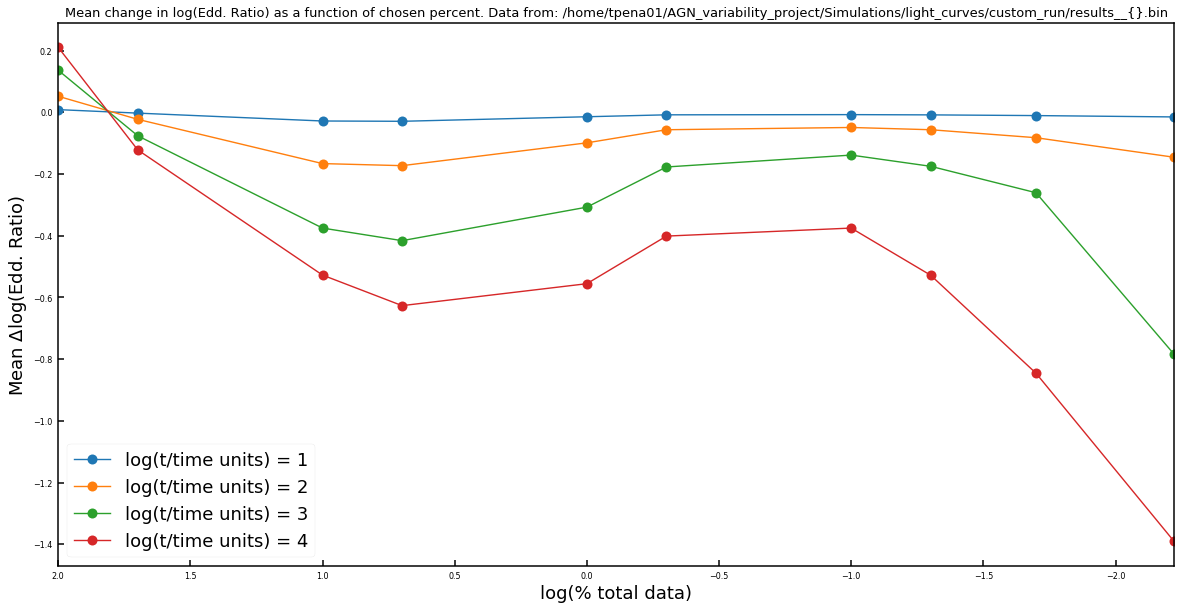

In [13]:
# PSD regime determination plot
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, figsize=(20, 10))
    
    ax.set_title('Mean change in log(Edd. Ratio) as a function of chosen percent. Data from: '+ data_path, fontsize=13)
    ax.tick_params(direction='in', length=6, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.set_xlabel('log(% total data)', fontsize=18)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('Mean $\Delta$log(Edd. Ratio)', fontsize=18)
    
    ax.plot(x, log_t_1, label='log(t/time units) = 1', marker='o', markersize=10)
    ax.plot(x, log_t_2, label='log(t/time units) = 2', marker='o', markersize=10)
    ax.plot(x, log_t_3, label='log(t/time units) = 3', marker='o', markersize=10)
    ax.plot(x, log_t_4, label='log(t/time units) = 4', marker='o', markersize=10)
    
    ax.legend(prop={'size':18})
    
plt.savefig('4-line_eddington_plot.pdf', bbox_inches='tight')  
plt.show()

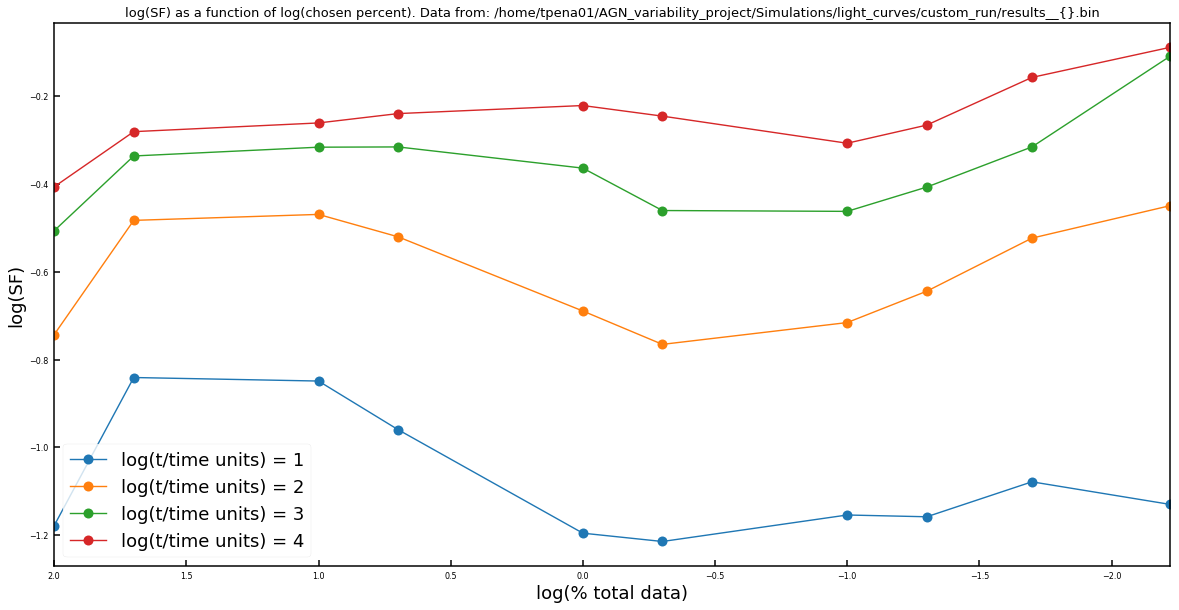

In [14]:
# Structure functions in a strange space
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, figsize=(20, 10))
    
    ax.set_title('log(SF) as a function of log(chosen percent). Data from: ' + data_path, fontsize=13)
    ax.tick_params(direction='in', length=6, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.set_xlabel('log(% total data)', fontsize=18)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('log(SF)', fontsize=18)
    
    ax.plot(x, log_t_1_stands, label='log(t/time units) = 1', marker='o', markersize=10)
    ax.plot(x, log_t_2_stands, label='log(t/time units) = 2', marker='o', markersize=10)
    ax.plot(x, log_t_3_stands, label='log(t/time units) = 3', marker='o', markersize=10)
    ax.plot(x, log_t_4_stands, label='log(t/time units) = 4', marker='o', markersize=10)
    
    ax.legend(prop={'size':18})
    
plt.savefig('4-line_SF_plot.pdf', bbox_inches='tight')  
plt.show()